# Analysis of used motorcycle prices

Fall 2024 Data Science Project

Contributors:

A: Project idea

B: Dataset Curation and Preprocessing

C: Data Exploration and Summary Statistics

D: ML Algorithm Design/Development

E: ML Algorithm Training and Test Data Analysis

F: Visualization, Result Analysis, Conclusion

G: Final Tutorial Report Creation

H: Additional (not listed above)

Brooke Guo: A, B, C, G, F (visualization and analysis), H (text editing)

We all had a part in thinking of a project idea and preprocessing our dataset. I specifically made the section titled "Selling Price vs Ex Showroom Price", the first section of Exploratory Analysis, wrote the tutorial text throughout the notebook (everything other than the Introduction/Conclusion), made the visualization for the ML section (titled "Visualization"), and made edits throughout all sections to ensure consistency of sections, titles, and labels.
<br><br>

Gloria Jeng: B, C, F

To see if there was a relationship between the selling price before and after 2015, I ran a z-test with and without outliers and also compared those differences. I reviewed all the analysis that was made, checked for inconsistencies, and then wrote the conclusion and key takeaways from our findings, focusing on significant variables that influenced the selling price of a motorcycle, how well our model performed, and if trends were found.
<br><br>

Chuanhai Xu: A, B, C, D, E, F, G

For data curation, I found the dataset we used for this project. For preprocessing, I extracted engine size information based on the names of motorcycles as well as added external links to readers who may want to learn more. For data exploration, I made the sections titled "Selling price vs Engine Size" and "KM Driven vs Number of Previous Owners." For ML algorithm design and analysis, I optimized it with the KNN imputer as well as found and plotted the elbow points for the number of trees in the random forest regressor and the number of neighbors for the KNN imputer. I also wrote the introduction of the report.
<br><br>

Angela Zhang: C, D, E, F

To assess the relationship between the owner type and the year of the vehicle, I conducted a chi-squared test of independence. I also designed the machine learning algorithm using Random Forest Regressor to predict vehicle selling prices. The algorithm incorporated key features such as km driven, year, owner type, and ex-showroom price. Lastly, I visualized the accuracy by showing the difference between predicted price and actual price.

# Introduction

Motorcycles are sick. Chuanhai, one of the contributors, recently obtained his motorcycle license and he and everyone else can't wait for him to buy one. However, he's running into a problem that [hundreds of thousands](https://www.statista.com/statistics/183549/us-sales-of-motorcycles-since-1990/) of people face each year: motorcycles are expensive, and of course, he wants to get the most bang for his buck.

A person's first bike is usually a used bike, since many people decide motorcycles aren't for them after owning one for a little while. In this project, we analyze which variables have the biggest impact on the price of used motorcycles and use this analysis to predict motorcycle prices. The results of this project will allow motorcycle enthusiasts to make better informed decisions when purchasing used motorcyles based on their own attributes.

This tutorial will walk through the steps of the Data Science Lifecycle:


1.   [Data Curation and Preprocessing](#curation)
2.   [Exploratory Data Analysis](#exploratory)
  *   [Comparing selling price to ex showroom price](#Comparing-selling-price-to-ex-showroom-price)
  *   [Selling price vs engine size](#Selling-price-vs-engine-size)
  *   [Km driven vs previous owners](#Km-driven-vs-previous-owners)
  *   [Correlation between number of owners and year](#Correlation-between-number-of-owners-and-year)
  *   [Selling price before/after 2015](#Selling-price-before-after-2015)
3.   [Primary Analysis](#primary)
4.   [Visualization](#visualization)
5.   [Insights and Conclusions](#insights)



old-woman-riding-motorcycle-with-blonde-hair-style_457222-5788.jpg.avif

<a name="curation"></a>
# Data Curation and Preprocessing

We obtained our data from a [dataset](https://www.kaggle.com/datasets/nehalbirla/motorcycle-dataset) from Kaggle. The data contains 1061 entries and 7 motorcycle features: name of the bike, selling price, year of purchase for the bike, seller type (individual or dealer), number of previous owners, kilometers driven, and ex showroom price (the price a dealer pays to the manufacturer).

Importing necessary libraries:

In [ ]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from matplotlib.lines import Line2D

Read csv into dataframe:

In [ ]:
original_df = pd.read_csv("bike_dataset.csv")
original_df

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN
...,...,...,...,...,...,...,...
1056,Activa 3g,17000,2010,Individual,1st owner,500000,52000.0
1057,Honda CB twister,16000,2012,Individual,1st owner,33000,51000.0
1058,Bajaj Discover 125,15000,2013,Individual,2nd owner,35000,57000.0
1059,Honda CB Shine,12000,2009,Individual,1st owner,53000,58000.0


A motorcycle's engine size is frequently used as a variable when analyzing the motorcycle. Since engine size can also be referred to as cubic capacity and since it's measured in cubic centimeters, the abbrievation "CC" is often used to refer to both the variable and the unit. It's easy to distinguish between the two usages in context. For more information, see [here](https://www.hypergogo.com/blogs/news/cc-in-motorcycles#:~:text=This%20number%20serves%20as%20an,capacity%20of%20250%20cubic%20centimeters.).

Oftentimes, a motorcycle's CC (or an approximation) is included in it's name. For example, a Royal Enfield Classic 350 has a 349cc engine, and a Royal Enfield Classic 500 has a 499cc engine. However, sometimes the CC is included in nontrivial ways, such as how a Yamaha MT-03 and a MT-09 have 321cc and 890cc engines, respectively. Other times, the name doesn't have any relationship to the CC at all.

For the purposes of this tutorial, we extract the CC from motorcycles with 3 digit long numbers in their names. 4 digits are likely to represent year instead, and the vast majority of bikes have CCs of at least 100.

Extract engine size from motorcycle name to new column "CC". When unable to extract, fill with *NaN*:

In [ ]:
def extract_cc(name):
  result = re.search(r'(\d{3})$', name)
  return int(result.group(0)) if result != None else pd.NA

original_df["CC"] = original_df["name"].apply(extract_cc)
original_df["CC"] = original_df["CC"].astype("Int64")
original_df

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,CC
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN,350
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN,<NA>
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0,<NA>
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0,<NA>
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN,<NA>
...,...,...,...,...,...,...,...,...
1056,Activa 3g,17000,2010,Individual,1st owner,500000,52000.0,<NA>
1057,Honda CB twister,16000,2012,Individual,1st owner,33000,51000.0,<NA>
1058,Bajaj Discover 125,15000,2013,Individual,2nd owner,35000,57000.0,125
1059,Honda CB Shine,12000,2009,Individual,1st owner,53000,58000.0,<NA>


The original dataset currency was in rupees, confirmed by manually comparing the bike's ex showroom price from the dataset to prices found online for several motorcycles.

Convert to USD using exchange rate as of early 2020 (most recent model year in the dataset):

In [ ]:
original_df["selling_price"] /= 71
original_df["ex_showroom_price"] /= 71

<a name="exploratory"></a>
# Exploratory Data Analysis

First, let's examine our column datatypes and generate some basic summary statistics of our data. This will enable us to identify any potentially interesting datapoints.

Column types:

In [ ]:
original_df.dtypes

,0
name,object
selling_price,float64
year,int64
seller_type,object
owner,object
km_driven,int64
ex_showroom_price,float64
CC,Int64


Summary statistics:

In [ ]:
original_df.describe(include="all")

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,CC
count,1061,1061.000000,1061.000000,1061,1061,1061.000000,626.000000,344.0
unique,279,NaN,NaN,2,4,NaN,NaN,<NA>
top,Bajaj Pulsar 150,NaN,NaN,Individual,1st owner,NaN,NaN,<NA>
freq,41,NaN,NaN,1055,924,NaN,NaN,<NA>
mean,NaN,839.973968,2013.867107,NaN,NaN,34359.833176,1238.855128,202.895349
std,NaN,793.018197,4.301191,NaN,NaN,51623.152702,1091.501228,119.364696
min,NaN,70.422535,1988.000000,NaN,NaN,350.000000,429.436620,14.0
25%,NaN,394.366197,2011.000000,NaN,NaN,13500.000000,772.563380,125.0
50%,NaN,633.802817,2015.000000,NaN,NaN,25000.000000,1024.683099,150.0
75%,NaN,985.915493,2017.000000,NaN,NaN,43000.000000,1225.795775,220.0


Next, let's further examine two columns: seller type, and number of previous owners.

Value counts of seller type:

In [ ]:
original_df['seller_type'].value_counts()

,count
seller_type,
Individual,1055
Dealer,6


Value counts of number of previous owners:

In [ ]:
original_df['owner'].value_counts()

,count
owner,
1st owner,924
2nd owner,123
3rd owner,11
4th owner,3


Most of the motorcycles in this dataset were sold by individuals, with less than 1% being sales from dealerships. In addition, we note that the majority of motorcycles are sold by 1st time or 2nd time owners, as opposed to 3+ time owners.

<a name="Comparing-selling-price-to-ex-showroom-price"></a>
## Selling Price vs Ex Showroom Price

Let's take a look at how ex showroom price compares to the current selling price. Recall that the showroom price is the price that the dealer pays to the manufacturer when the motorcycle is sold.

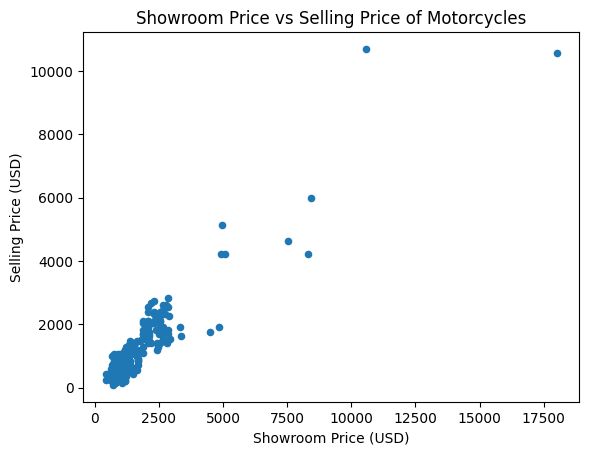

In [ ]:
data = original_df.copy()

data.plot.scatter(x='ex_showroom_price', y='selling_price')
plt.title('Showroom Price vs Selling Price of Motorcycles')
plt.xlabel("Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

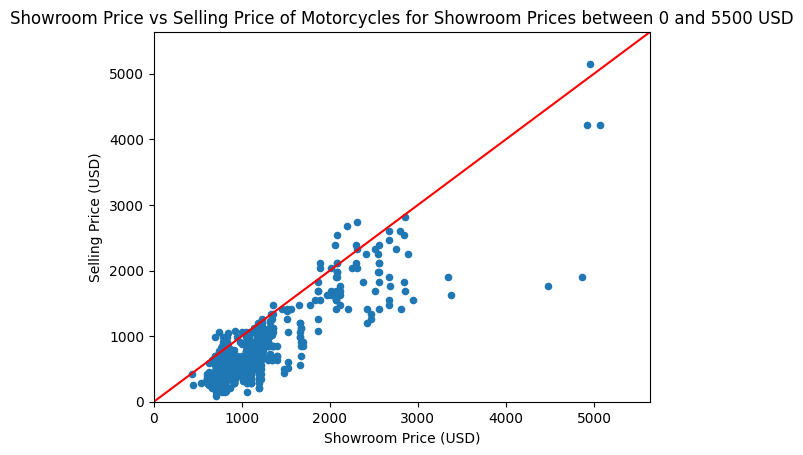

In [ ]:
# zoomed in
data.plot.scatter(x='ex_showroom_price', y='selling_price')
plt.xlim(0,.4*1000000 / 71)
plt.ylim(0,.4*1000000 / 71)
plt.plot([0,.4*1000000], [0,.4*1000000], color='red')
plt.title('Showroom Price vs Selling Price of Motorcycles for Showroom Prices between 0 and 5500 USD')
plt.xlabel("Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

Some observations we make here include:

- Selling prices tend to be lower than showroom prices
- Most of our data is in range of 5500 USD

### Closer inspection

#### Pricing and Ownership

Now, let's visualize our pricing with information about the number of previous owners a particular motorbike had. In the previous section, we noticed that most of the bikes only had 1 previous owner, and especially that not many bikes had 3+ previous owners. Therefore, we will group them together as an "Other" category for visualization here.

In [ ]:
colors = []
for own_num in data['owner']:
    if own_num == '1st owner':
        colors.append('orange')
    elif own_num == '2nd owner':
        colors.append('green' )
    else:
        colors.append('black')

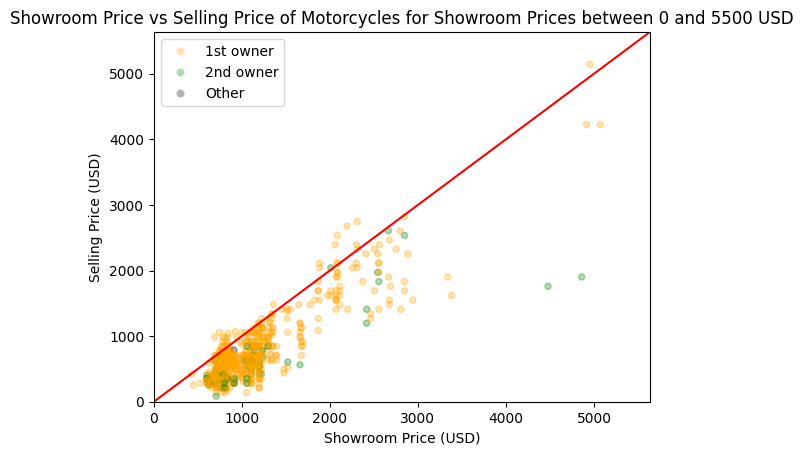

In [ ]:
data.plot.scatter(x='ex_showroom_price', y='selling_price', c=colors, alpha=.3)
plt.xlim(0,.4*1000000 / 71)
plt.ylim(0,.4*1000000 / 71)
plt.plot([0,.4*1000000 / 71], [0,.4*1000000 / 71], color='red')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='1st owner',
                          markerfacecolor='orange', alpha=.3),
                   Line2D([0], [0], marker='o', color='w', label='2nd owner',
                          markerfacecolor='green', alpha=.3),
                   Line2D([0], [0], marker='o', color='w', label='Other',
                          markerfacecolor='black', alpha=.3)]
plt.legend(handles=legend_elements)
plt.title('Showroom Price vs Selling Price of Motorcycles for Showroom Prices between 0 and 5500 USD')
plt.xlabel("Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

#### Pricing and Bike Model Year

Here, we perform a similar visualization to visualize possible trends in purchase price by year purchased. Specifically, let's visualize by purchase before or after the average year of purchase recorded in our dataset.

In [ ]:
mean_year = data['year'].mean()
mean_year

2013.8671065032988

In [ ]:
colors = []
for year_num in data['year']:
    if year_num < mean_year:
        colors.append('orange')
    elif year_num > mean_year:
        colors.append('green' )

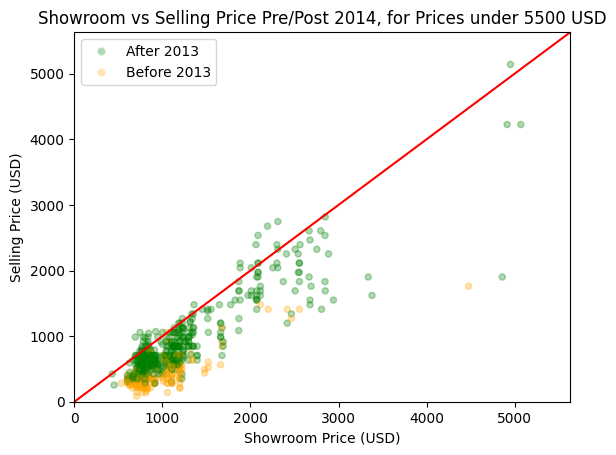

In [ ]:
data.plot.scatter(x='ex_showroom_price', y='selling_price', c=colors, alpha=.3)
plt.xlim(0,.4*1000000 / 71)
plt.ylim(0,.4*1000000 / 71)
plt.plot([0,.4*1000000], [0,.4*1000000], color='red')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='After 2013',
                          markerfacecolor='green', alpha=.3),
                   Line2D([0], [0], marker='o', color='w', label='Before 2013',
                          markerfacecolor='orange', alpha=.3)]

# # Create the figure
# fig, ax = plt.subplots()
# ax.legend(handles=legend_elements, loc='center')
plt.title('Showroom vs Selling Price Pre/Post 2014, for Prices under 5500 USD')
plt.legend(handles=legend_elements)
plt.xlabel("Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

Even though we are restricting to the range of 5500 USD, most of our points are still clustered near 1000. Let's perform a log scaling to see our results better.

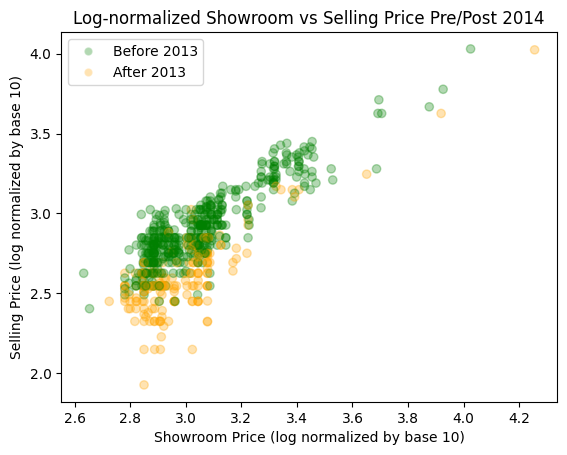

In [ ]:
# graphing on a log scale

plt.scatter(x=data['ex_showroom_price'].apply(math.log10), y=data['selling_price'].apply(math.log10), c=colors, alpha=.3)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Before 2013',
                          markerfacecolor='green', alpha=.3),
                   Line2D([0], [0], marker='o', color='w', label='After 2013',
                          markerfacecolor='orange', alpha=.3)]

plt.title('Log-normalized Showroom vs Selling Price Pre/Post 2014')
plt.legend(handles=legend_elements)
plt.xlabel("Showroom Price (log normalized by base 10)")
plt.ylabel("Selling Price (log normalized by base 10)")
plt.show()

Visually, it seems like there is a divide between the selling price vs showroom price pre and post 2014. Let's dive deeper into this in the next section.

### Statistical testing

In the previous section, we noticed that there seems to be a visual divide between cost differences (selling vs showroom price) pre and post 2014. A T-test will tell us if, on average, this difference is significant between pre/post 2014.

In [ ]:
temp = data.loc[data['year'] < mean_year][['ex_showroom_price','selling_price']].dropna()
print('Data points in set 1: %d' % len(temp))
pre14 = (temp['selling_price'] - temp['ex_showroom_price']).to_list()  # This is the cost difference between selling and showroom price
temp = data.loc[data['year'] > mean_year][['ex_showroom_price','selling_price']].dropna()
print('Data points in set 2: %d' % len(temp))
post14 = (temp['selling_price'] - temp['ex_showroom_price']).to_list()

ttest_ind(pre14,post14)

Data points in set 1: 185
Data points in set 2: 441


TtestResult(statistic=-7.473396509504962, pvalue=2.6534062920839427e-13, df=624.0)

Our T-test results suggest that there is a significant difference between the cost difference pre and post 2014! We also previously noted that using the log scale seemed to be a much better tool for visualization. Let's conduct the same test on the log scaled data.

In [ ]:
temp = data.loc[data['year'] < mean_year][['ex_showroom_price','selling_price']].dropna()
pre14 = (temp['selling_price'].apply(math.log10) - temp['ex_showroom_price'].apply(math.log10)).to_list()
temp = data.loc[data['year'] > mean_year][['ex_showroom_price','selling_price']].dropna()
post14 = (temp['selling_price'].apply(math.log10) - temp['ex_showroom_price'].apply(math.log10)).to_list()


# Conduct the one-way ANOVA
ttest_ind(pre14,post14)

TtestResult(statistic=-21.136505708831464, pvalue=3.3704996467377043e-75, df=624.0)

With the log scaled data, a T-test finds an even more significant difference.

<a name="Selling-price-vs-engine-size"></a>
## Selling price vs Engine Size

Next, let's examine differences in selling price based on motorcycle engine size. We plot a blue line of dimension 1 using numpy.polyfit to visualize a trend line for the data.

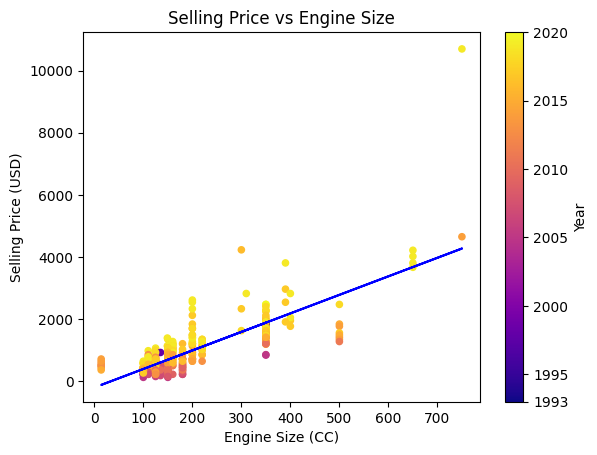

In [ ]:
df = original_df.copy()
temp_df = df[df["CC"].notna()]

ax = temp_df.plot.scatter(x='CC', y = 'selling_price', c=temp_df["year"], cmap=plt.cm.plasma, colorbar=False)
plt.xlabel('Engine Size (CC)')
plt.ylabel('Selling Price (USD)')
plt.title('Selling Price vs Engine Size')

colorbar = plt.colorbar(ax.collections[0], ax=ax, ticks=[1993, 1995, 2000, 2005, 2010, 2015, 2020])
colorbar.set_label('Year')

m, b = np.polyfit(temp_df["CC"], temp_df["selling_price"], 1)   # restrict the polynomial to degree 1
plt.plot(temp_df["CC"], m*temp_df["CC"]+b, color="blue")

plt.show()

We see a few data points much higher than our trend line, specifically above 8000 USD. Let's see how many of these outliers we have.

In [ ]:
df[df["selling_price"] > 8000]

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,CC
134,Harley-Davidson Street Bob,10563.380282,2013,Individual,2nd owner,12000,18000.000000,<NA>
295,Suzuki GSX S750,10704.225352,2019,Individual,1st owner,2800,10591.830986,750


So we have two outliers.

Next, let's check the correlations between our variables. This will help us determine if any variables might be strongly connected. A correlation of magnitude 1, for example, means our variables are very strongly linked, while a correlation of magnitude 0 suggests that our variables are very weakly linked.

In [ ]:
correlation = temp_df["CC"].corr(temp_df["selling_price"])
print(f"Correlation between Engine Size and Selling Price: {correlation:.3f}")

correlation = df["year"].corr(df["selling_price"])
print(f"Correlation between Year and Selling price: {correlation:.3f}")

Correlation between Engine Size and Selling Price: 0.787
Correlation between Year and Selling price: 0.402


Here, we see a strong positive linear relationship between engine size and selling price, and a moderate positive linear relationship between year and selling price.

From the previous section, we saw most of the data lying in the sub 300 CC range. Let's take a closer look by visualization and checking our correlations here.

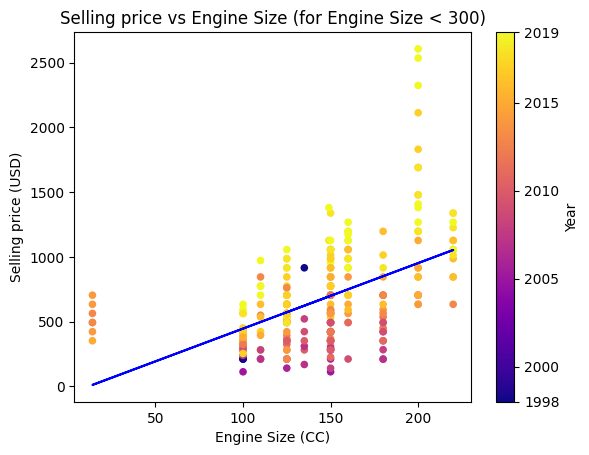

In [ ]:
temp_df = df[df["CC"].notna()]
temp_df = temp_df[temp_df["CC"] < 300]
ax = temp_df.plot.scatter(x='CC', y = 'selling_price', c=temp_df["year"], cmap=plt.cm.plasma, colorbar=False)
plt.xlabel('Engine Size (CC)')
plt.ylabel('Selling price (USD)')
plt.title('Selling price vs Engine Size (for Engine Size < 300)')

colorbar = plt.colorbar(ax.collections[0], ax=ax, ticks=[1998, 2000, 2005, 2010, 2015, 2019])
colorbar.set_label('Year')

m, b = np.polyfit(temp_df["CC"], temp_df["selling_price"], 1)
plt.plot(temp_df["CC"], m*temp_df["CC"]+b, color="blue")

plt.show()

In [ ]:
correlation = temp_df["CC"].corr(temp_df["selling_price"])
print(f"Correlation between Engine Size and Selling Price for CC < 300: {correlation:.3f}")

correlation = temp_df["year"].corr(temp_df["selling_price"])
print(f"Correlation between Year and selling price for CC < 300: {correlation:.3f}")

Correlation between Engine Size and Selling Price for CC < 300: 0.506
Correlation between Year and selling price for CC < 300: 0.616


Here, we see moderate positive linear relationships between engine size and selling price, and year and selling price for engine size < 300cc.

<a name="Km-driven-vs-previous-owners"></a>
## KM Driven vs Number of Previous Owners

Now let's see if we see any trends in the number of kilometers driven on a motorbike based on its number of previous owners. First, let's draw a bar plot to visualize the mean kilometers driven by the number of previous owners.

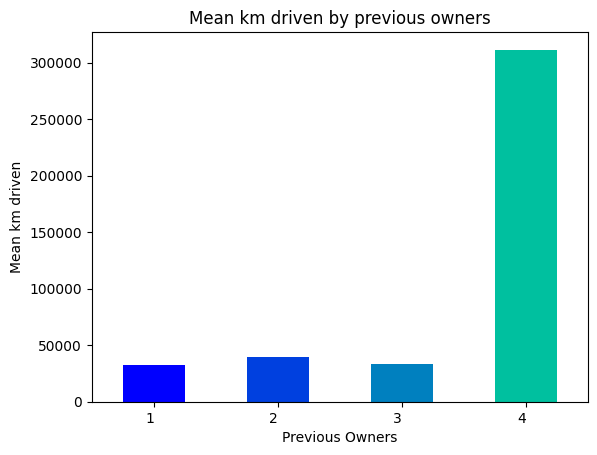

In [ ]:
grouped_data = df.groupby('owner')['km_driven'].mean()

ax = grouped_data.plot.bar(color=plt.get_cmap("winter")(np.arange(4) / 4))
plt.xlabel('Previous Owners')
plt.ylabel('Mean km driven')
plt.title('Mean km driven by previous owners')

ax.set_xticklabels([label.get_text()[0] for label in ax.get_xticklabels()], rotation=0, ha="right")

plt.show()

Woah! We see a lot more kilometers driven when there were 4 previous owners! But we saw previously that there aren't very many of these owners. Let's see which entries correspond to having 4 previous owners.

In [ ]:
display(df[df["owner"] == "4th owner"])

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,CC
311,Harley-Davidson Street 750,4647.887324,2014,Individual,4th owner,6500,7521.126761,750
642,TVS Apache RTR 160,211.267606,2009,Individual,4th owner,880000,NaN,160
698,Hero Honda CBZ,140.845070,2000,Individual,4th owner,48000,NaN,<NA>


Entry 642 has *way* more kilometers driven than its counterparts. Let's remove this outlier.

In [ ]:
df.drop(642, inplace=True)

display(df[df["owner"] == "4th owner"])

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price,CC
311,Harley-Davidson Street 750,4647.887324,2014,Individual,4th owner,6500,7521.126761,750
698,Hero Honda CBZ,140.845070,2000,Individual,4th owner,48000,NaN,<NA>


Now that our outlier is removed, let's revisualize our mean kilometers driven.

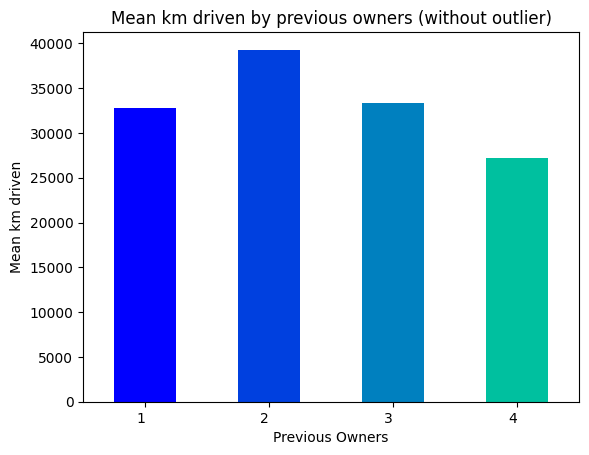

In [ ]:
grouped_data = df.groupby('owner')['km_driven'].mean()

ax = grouped_data.plot.bar(color=plt.get_cmap("winter")(np.arange(4) / 4))
plt.xlabel('Previous Owners')
plt.ylabel('Mean km driven')
plt.title('Mean km driven by previous owners (without outlier)')

ax.set_xticklabels([label.get_text()[0] for label in ax.get_xticklabels()], rotation=0, ha="right")

plt.show()

Hmm... the number of kilometers driven seems to be pretty consistent among the 4 groups. Let's see what a one-way ANOVA tells us. We use this test to determine if there are significant differences in averages across multiple groups. In this case, we have four groups.

In [ ]:
grouped_data = [group['km_driven'].values for name, group in df.groupby('owner')]
print(stats.f_oneway(*grouped_data).pvalue)

0.5085253640620843


One-way ANOVA gives us a p-value of 0.51, which is much greater than a significant p-value of 0.05. We conclude that there does not seem to be significant difference between km driven and number of previous owners.

<a name="Correlation-between-number-of-owners-and-year"></a>
## Number of Previous Owners vs Year


Finally, let's look at the relationship between the number of previous owners and the year of purchase of the bike. To do this, let's perform a chi-square analysis between the number of owners and the year of purchase. Here, we use a chi-square analysis because we want to compare differences between two categorical variables. Our null hypothesis here is that there is no significant association between the number of previous owners and the year of purchase.

In [ ]:
df = original_df.copy()

In [ ]:
contingency_table = pd.crosstab(df['owner'], df['year'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"P-Value: {p}")

P-Value: 8.262405973018963e-27


Our p-value is much smaller than 0.05, so we reject the null hypothesis. This suggests that there is a statistically significant association between the owner and the year. In other words, it is likely that the ownership type (1st or 2nd) influences or is related to to the year the vehicle was sold.

Next, let's visualize these differences in purchase year based on the number of previous owners.

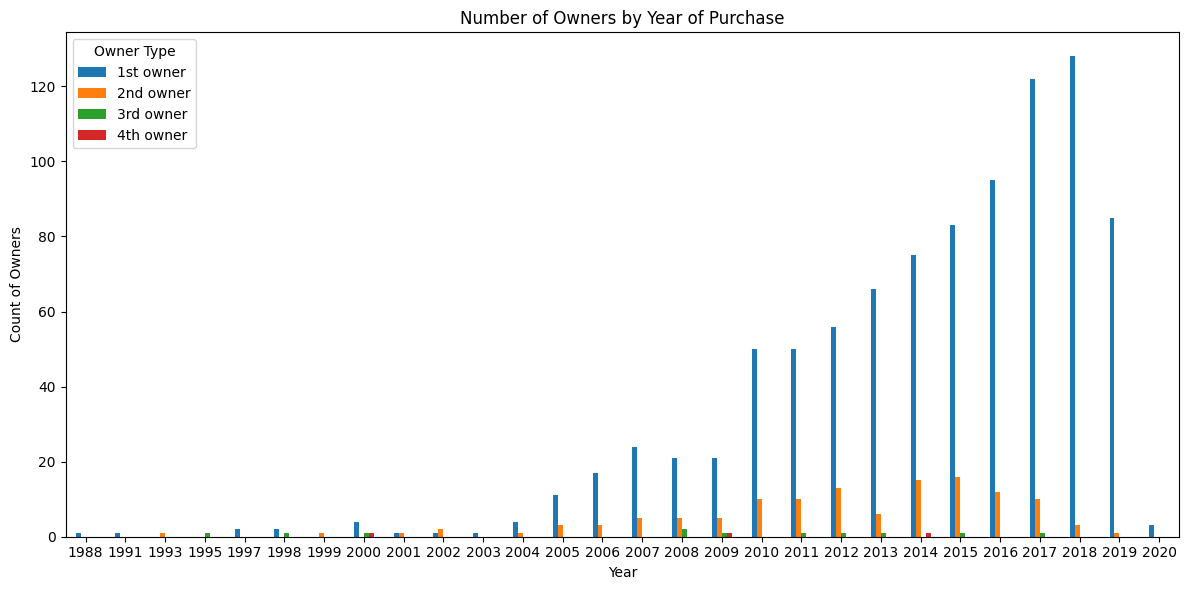

In [ ]:
count_df = df.groupby(['year', 'owner']).size().unstack(fill_value=0)

count_df.plot(kind='bar', figsize=(12, 6))

# Customize the plot
plt.title('Number of Owners by Year of Purchase')
plt.xlabel('Year')
plt.ylabel('Count of Owners')
plt.xticks(rotation=0)
plt.legend(title='Owner Type')
plt.tight_layout()
plt.show()

It appears that the number of bikes with 1 previous owner increases with the year of purchase. The number of bikes with 2 previous owners seems to follow a similar trend on a much smaller scale until 2015, where it begins dropping. We also see a sudden drop in sales in 2020 in especially bikes with 1 previous owner.

<a name="Selling-price-before-after-2015"></a>
### Selling price before/after 2015

As an extension, let's group our years into pre/post 2015 this time and look for relationships in selling price and year. We can perform a z-test to tell us if there is a significant difference between these groups, which is appropriate because we have large size groups and can take advantage of the Central Limit Theorem (large scale samples approach a Gaussian distribution).

In [ ]:
bike_data = original_df.copy()
bike_data_clean = bike_data.dropna(subset=['selling_price', 'year'])

In [ ]:
group_after_2015 = bike_data_clean[bike_data_clean['year'] > 2015]['selling_price']
group_before_2015 = bike_data_clean[bike_data_clean['year'] <= 2015]['selling_price']

mean_after_2015 = np.mean(group_after_2015)
mean_before_2015 = np.mean(group_before_2015)

std_after_2015 = np.std(group_after_2015, ddof=1)
std_before_2015 = np.std(group_before_2015, ddof=1)

n_after_2015 = len(group_after_2015)
n_before_2015 = len(group_before_2015)

In [ ]:
z_score = (mean_after_2015 - mean_before_2015) / np.sqrt((std_after_2015**2 / n_after_2015) + (std_before_2015**2 / n_before_2015))
p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))


mean_after_2015 = float(mean_after_2015)
mean_before_2015 = float(mean_before_2015)
z_score = float(z_score)
p_value = float(p_value)
mean_after_2015, mean_before_2015, z_score, p_value

(1196.448009797918, 567.1319397248716, 13.268690643803945, 0.0)

Our p-value here is 0! We conclude that the means of selling prices before and after 2015 are statistically significantly different.

Let's see this in a plot.

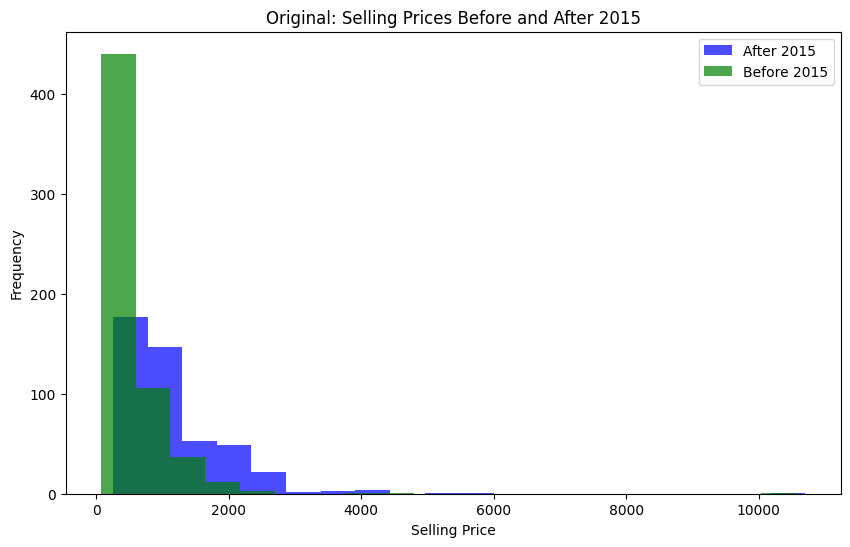

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(group_after_2015, bins=20, alpha=0.7, label="After 2015", color="blue")
plt.hist(group_before_2015, bins=20, alpha=0.7, label="Before 2015", color="green")
plt.title('Original: Selling Prices Before and After 2015')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


Our data seems to be skewed very rightwards! In the previous sections we noted some outliers. Let's perform an analysis to get rid of these outliers. To do this, we can calculate the quartiles of our data, and get rid of everything that is 1.5 * the interquartile range beyond our first and third quartiles. This will help us eliminate data that is spread too far away from our median selling price.

In [ ]:
Q1 = bike_data_clean['selling_price'].quantile(0.25)
Q3 = bike_data_clean['selling_price'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
bike_data_no_outliers = bike_data_clean[(bike_data_clean['selling_price'] >= lower_bound) & (bike_data_clean['selling_price'] <= upper_bound)]

In [ ]:
group_after_2015_no_outliers = bike_data_no_outliers[bike_data_no_outliers['year'] > 2015]['selling_price']
group_before_2015_no_outliers = bike_data_no_outliers[bike_data_no_outliers['year'] <= 2015]['selling_price']

mean_after_2015_no_outliers = np.mean(group_after_2015_no_outliers)
mean_before_2015_no_outliers = np.mean(group_before_2015_no_outliers)

std_after_2015_no_outliers = np.std(group_after_2015_no_outliers, ddof=1)
std_before_2015_no_outliers = np.std(group_before_2015_no_outliers, ddof=1)

n_after_2015_no_outliers = len(group_after_2015_no_outliers)
n_before_2015_no_outliers = len(group_before_2015_no_outliers)

Let's see if removing outliers changes our z-test results.

In [ ]:
z_score_no_outliers = (mean_after_2015_no_outliers - mean_before_2015_no_outliers) / np.sqrt((std_after_2015_no_outliers**2 / n_after_2015_no_outliers) + (std_before_2015_no_outliers**2 / n_before_2015_no_outliers))
p_value_no_outliers = 2 * (1 - stats.norm.cdf(abs(z_score_no_outliers)))


mean_after_2015_no_outliers = float(mean_after_2015_no_outliers)
mean_before_2015_no_outliers = float(mean_before_2015_no_outliers)
z_score_no_outliers = float(z_score_no_outliers)
p_value_no_outliers = float(p_value_no_outliers)

mean_after_2015_no_outliers, mean_before_2015_no_outliers, z_score_no_outliers, p_value_no_outliers

(907.8236118280362, 519.6061810049487, 16.785884924165902, 0.0)

After removing outliers, we still see a significant difference. Let's make one more visualization:

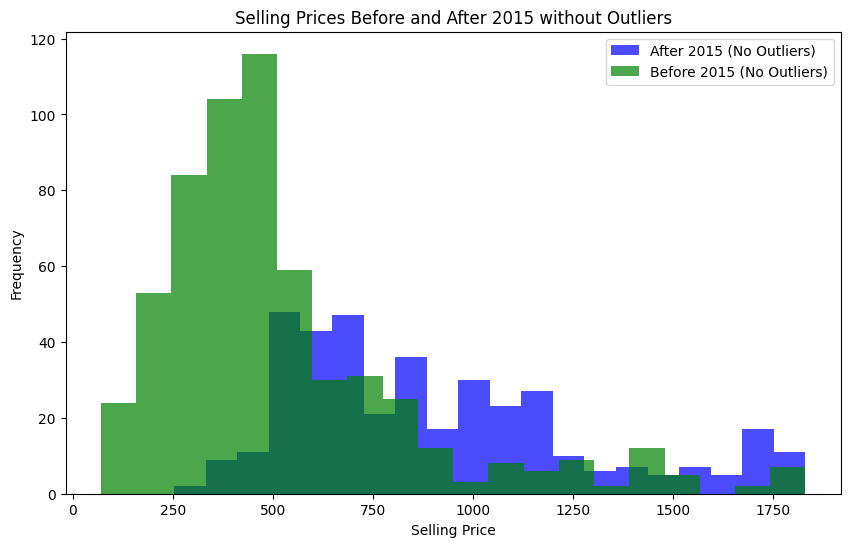

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(group_after_2015_no_outliers, bins=20, alpha=0.7, label="After 2015 (No Outliers)", color="blue")
plt.hist(group_before_2015_no_outliers, bins=20, alpha=0.7, label="Before 2015 (No Outliers)", color="green")
plt.title('Selling Prices Before and After 2015 without Outliers')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<a name="primary"></a>
# Primary Analysis

Ultimately, an individual who wants to make a purchase wants to be informed on a good price for a bike that they may want! In our final analysis, we want to predicting the selling price of a bike based on the kilometers driven, year, owner, and ex showroom price.

Missing values in the ex_showroom_price column were replaced with the median to ensure no null values disrupt the model training. The owner column, a categorical variable, was one-hot encoded to convert it into numerical format for the model.

To perform our analysis, we will fit a Random Forest model. This is an ensemble model which first builds several Decision Trees, then combines then to create a good tool for regression or categorization. We use this model because we want the model to consider the importances of features and avoid overfitting that is characteristic of a Decision Tree. In addition, we want our model to output a price; in other words, perform regression, which a Random Forest is also capable of. Finally, a Random Forest model is able to tell us what feature most significantly impacts the selling price. This is crucial information for a potential buyer: it tells them what feature is most likely to make a bike more or less expensive.

First, let's import relevant libraries:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

Now we perform our analysis. We set aside 20% of the data for testing, fit the RandomForestRegressor on our training data, and test its performance.

In [ ]:
data_preprocessed = original_df.copy()
data_preprocessed["ex_showroom_price"] = data_preprocessed['ex_showroom_price'].fillna(original_df['ex_showroom_price'].median())
data_preprocessed = data_preprocessed[['selling_price', 'km_driven', 'year', 'owner', 'ex_showroom_price']].dropna()
data_preprocessed = pd.get_dummies(data_preprocessed, columns=['owner'], drop_first=True)

X = data_preprocessed.drop('selling_price', axis=1)
y = data_preprocessed['selling_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 114736.24168943001
R² Score: 0.7806479066853298


Our results show a high MSE, which may be due to the fact that the range of bike prices are high, and thus absolute errors are largely magnified. We also observe an R² of 0.698, indicating the model explains most of the variability in the selling price and is fit well for prediction purposes. This suggests that our model captures most of the relationships between the features and the selling price.

Upon further inspection, a few tiny optimizations can be made to the model. For one, it was imputing the median for missing ex_showroom_price data. Since we have a relatively large amount of data where ex_showroom_price isn't missing, we found that the model can be more accurate if we removed the missing data points entirely.

Additionally, instead of imputing the median for missing ex_showroom_price test data (as well as dropping test data when other columns had missing values), we now only drop missing values (from any column) on training data, and use a K nearest neighbors imputer on missing values in test data.


In [ ]:
from sklearn.impute import KNNImputer

data_preprocessed = original_df.copy()
data_preprocessed = pd.get_dummies(data_preprocessed, columns=['owner'], drop_first=True)

# remove categorical columns except the one-hot encoded owner columns
X = data_preprocessed.drop(['selling_price', "seller_type", "name", "CC"], axis=1)
y = data_preprocessed['selling_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# drop missing values on train data by combining X and y train data,
# dropping missing values, then separating into X and y again
train = X_train
train["selling_price"] = y_train
train = train.dropna()
X_train = train.drop("selling_price", axis=1)
y_train = train["selling_price"]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use a K nearest neighbors imputer with k = 2
imputer = KNNImputer(n_neighbors=2)
X_test_new = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

# Make predictions on the test set
y_pred = model.predict(X_test_new)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Squared Error (MSE): 113340.01503805844
R² Score: 0.7833172048443988


While the R^2 score increase isn't very large compared to the previous model, it's important to take into account that the new model is also testing on data with missing input values, whereas the previous model did not test on such data. So, using a K nearest neighbors imputer allowed us to optimize our prediction model.

Next, we can find the elbow points for both the n_estimators parameter of RandomForestRegressor, which is the number of trees in the forest, as well as the number of neighbors for the imputer. Elbow points refer to the optimal values for hyper-parameters (a parameter of the model instead of the data), and finding the right ones can help optimize and fine tune a model. We start with finding the elbow point for the number of trees:

Best number of trees: 13
Best Mean Squared Error (MSE): 109768.90509003053
Best R² Score: 0.7901444325016991


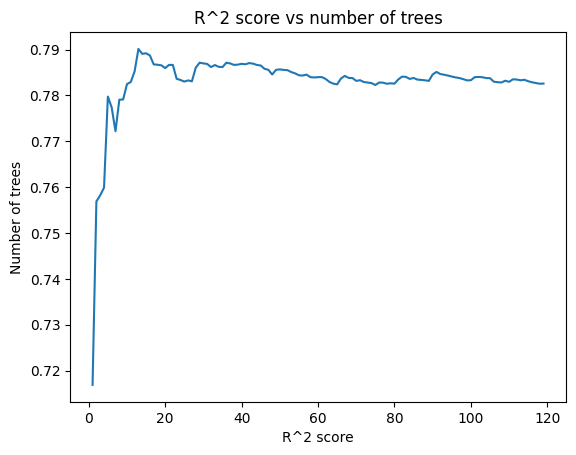

In [ ]:
mse_list = []
r2_list = []

# list of number of trees to use
n = list(range(1, 120))

for trees in n:
  # Train a Random Forest Regressor with different numbers of trees
  model = RandomForestRegressor(n_estimators=trees, random_state=42)
  model.fit(X_train_new, y_train_new)

  # Use a K nearest neighbors imputer with k = 2
  imputer = KNNImputer(n_neighbors=2)
  X_test_new = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

  # Make predictions on the test set
  y_pred = model.predict(X_test_new)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  mse_list.append(mse)
  r2_list.append(r2)

# Find the number of trees with the highest r^2 score
best_n = np.argmax(r2_list)
print(f"Best number of trees: {n[best_n]}")
print(f"Best Mean Squared Error (MSE): {mse_list[best_n]}")
print(f"Best R² Score: {r2_list[best_n]}")

plt.plot(n, r2_list)
plt.title("R^2 score vs number of trees")
plt.xlabel("R^2 score")
plt.ylabel("Number of trees")
plt.show()

Next, for the elbow point of K in the K nearest neighbors imputer:

Best number of neighbors: 2
Best Mean Squared Error (MSE): 109768.90509003053
Best R² Score: 0.7901444325016991


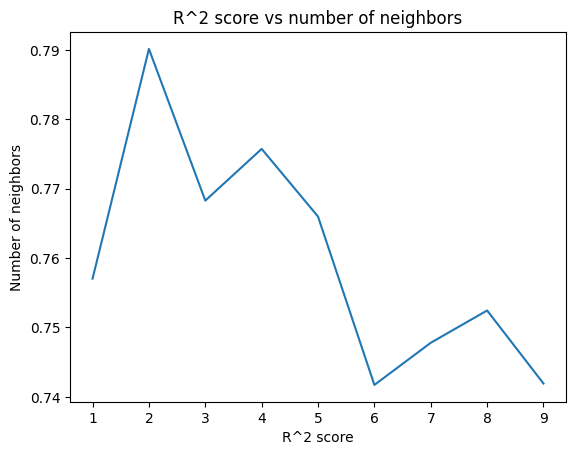

In [ ]:
mse_list = []
r2_list = []

# list of number of neighbors to use
ks = list(range(1, 10))

for k in ks:
  # Train a Random Forest Regressor with 13 trees
  model = RandomForestRegressor(n_estimators=13, random_state=42)
  model.fit(X_train_new, y_train_new)

  # Use a K nearest neighbors imputer with different numbers of neighbors
  imputer = KNNImputer(n_neighbors=k)
  X_test_new = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

  # Make predictions on the test set
  y_pred = model.predict(X_test_new)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  mse_list.append(mse)
  r2_list.append(r2)

# Find the number of neighbors with the highest r^2 score
best_n = np.argmax(r2_list)
print(f"Best number of neighbors: {n[best_n]}")
print(f"Best Mean Squared Error (MSE): {mse_list[best_n]}")
print(f"Best R² Score: {r2_list[best_n]}")

plt.plot(ks, r2_list)
plt.title("R^2 score vs number of neighbors")
plt.xlabel("R^2 score")
plt.ylabel("Number of neighbors")
plt.show()

So, based on the 2 graphs above, we have determined that the elbow points for the number of trees and the number of neighbors to be 13 and 2, respectively. These hyper-parameter values optimize the accuracy of our model, and helped increase the R^2 score on our test data by almost 0.01, meaning our model is able to explain almost 1% more of the variability in selling price.

<a name="visualization"></a>
## Visualization

First, let's extract the most significant feature from our Random Forest model.

In [ ]:
features = pd.Series(model.feature_importances_, index=X_train.columns)
features = features.sort_values(ascending=False)
features

,0
ex_showroom_price,0.894948
year,0.055295
owner_2nd owner,0.029048
km_driven,0.020574
owner_4th owner,0.000091
owner_3rd owner,0.000043


Our most significant feature appears to be the showroom price! Let's visualize our model performance based on this feature by plotting our predictions for selling prices based on showroom price against the actual selling price.

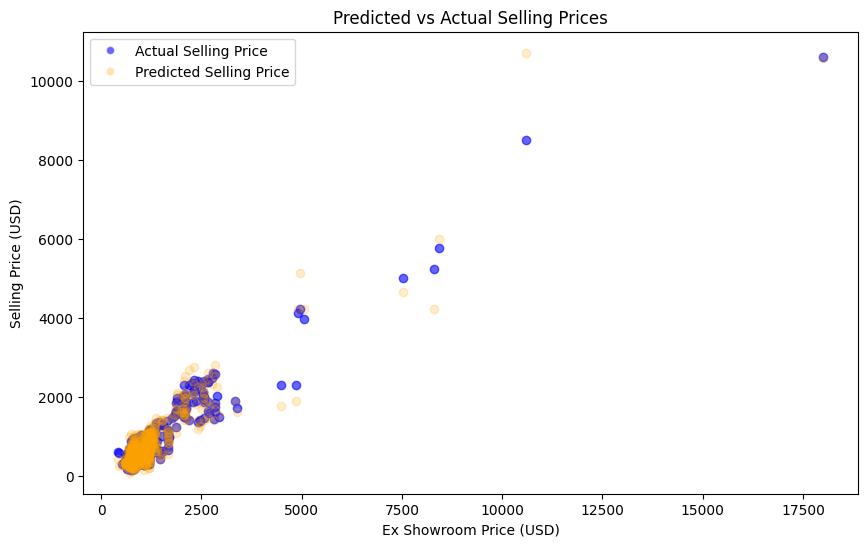

In [ ]:
plt.figure(figsize=(10, 6))
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actual Selling Price',
                          markerfacecolor='blue', alpha=.6),
                   Line2D([0], [0], marker='o', color='w', label='Predicted Selling Price',
                          markerfacecolor='orange', alpha=.3)]

plt.scatter(X_train['ex_showroom_price'], y_train_pred, alpha=0.6, color='blue')
plt.scatter(X_test['ex_showroom_price'], y_pred, alpha=0.6, color='blue')

plt.scatter(X_train['ex_showroom_price'], y_train, alpha=0.2, color='orange')
plt.scatter(X_test['ex_showroom_price'], y_test, alpha=0.2, color='orange')

plt.title("Predicted vs Actual Selling Prices")
plt.legend(handles=legend_elements)
plt.xlabel("Ex Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

Visually, the orange dots are all close to the blue dots. This suggests that the predicted prices on the entire dataset are close to the actual prices. But this plot includes *all* of the data, including the data that our model is trained on. Let's take a closer look at just the test data:

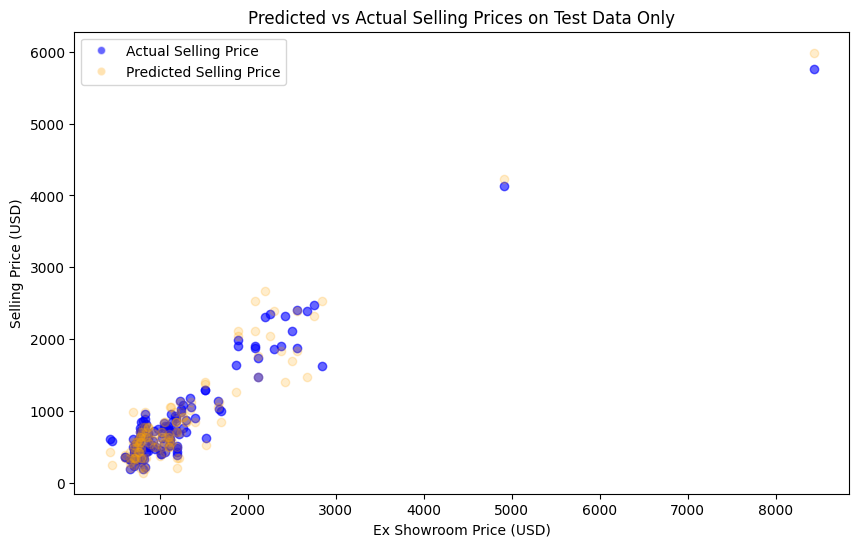

In [ ]:
plt.figure(figsize=(10, 6))
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Actual Selling Price',
                          markerfacecolor='blue', alpha=.6),
                   Line2D([0], [0], marker='o', color='w', label='Predicted Selling Price',
                          markerfacecolor='orange', alpha=.3)]
plt.scatter(X_test['ex_showroom_price'], y_pred, alpha=0.6, color='blue')

plt.scatter(X_test['ex_showroom_price'], y_test, alpha=0.2, color='orange')

plt.title("Predicted vs Actual Selling Prices on Test Data Only")
plt.legend(handles=legend_elements)
plt.xlabel("Ex Showroom Price (USD)")
plt.ylabel("Selling Price (USD)")
plt.show()

Here, the predicted orange dots are still very close to the actual blue dots, indicating that our model performs well in its prediction.

<a name="insights"></a>
# Insights and Conclusions


Motorcycles are a popular choice of transportation and recreation, however, determining the value of one can be a difficult and time-consuming task. To address this issue, our project focuses on analyzing the factors that influence motorcycle prices and developing a model to predict them accurately.

*   **Key Insights**: Several variables can significantly affect the selling price of a used motorcycle. These include the engine size, the number of kilometers driven, the year of manufacture, the ex-showroom price, and the number of previous owners. Our analysis shows that newer motorcycles with lower mileage tend to sell for higher prices, while a greater number of previous owners typically reduces the selling price. Among all factors, the ex-showroom price was the most influential variable.

*  **Model Performance**: The predictive model performs well for motorcycles in lower and mid-price ranges, with predicted values aligning closely with actual selling prices. However, predictions for high-priced motorcycles show greater variance, likely due to the smaller representation of these bikes in the dataset.

*   **Trends and Takeaways**: Visual comparisons of selling price with other variables, such as engine size and ex-showroom price, reveal clear trends. For instance, motorcycles with larger engine capacities generally have higher prices, reflecting market expectations.


This tutorial walks through the Data Science Lifecycle, from data exploration and visualization to modeling and evaluation. It serves as practical guide to understanding the relationships between variables and their impact on motorcycle prices. Readers will gain valuable insights into the factors that shape motorcycle pricing and learn how to apply similar techniques to make data-driven decisions. Whether you're a motorcycle enthusiast or a data science practitioner, this analysis offers a clear and actionable approach to understanding and predicting used motorcycle prices.